The dataset used in this notebook is MNIST dataset. You can download it by using built in TF functions.

In [1]:
import tensorflow as tf
from autoencoders_helper_functions import *
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


![](deep_af_autoencoder.png)

The Autoencoder used in this notebook has the same architecture as one used in the Deep Convolutional Autoencoder project. The only difference is that we add noise to the input images.

### Step 1. Placeholders

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1])
targets = tf.placeholder(tf.float32, [None, 28, 28, 1])

### Step 2. Define the architecture of the Autoencoder

In [4]:
encoder = convd2_custom(inputs, 3, 1, 16, max_pool=True)
encoder = convd2_custom(encoder, 3, 16, 8, max_pool=True)
encoder = convd2_custom(encoder, 3, 8, 8, max_pool=True)
encoder = convd2_custom(encoder, 3, 8, 8, max_pool=True)

decoder = tf.image.resize_nearest_neighbor(encoder, (7, 7))
decoder = convd2_custom(decoder, 3, 8, 8, max_pool=False)
decoder = tf.image.resize_nearest_neighbor(decoder, (14, 14))
decoder = convd2_custom(decoder, 3, 8, 8, max_pool=False)
decoder = tf.image.resize_nearest_neighbor(decoder, (28, 28))
decoder = convd2_custom(decoder, 3, 8, 16, max_pool=False)

logits = convd2_custom(decoder, 3, 16, 1, max_pool=False, activation=None)
decoded = tf.nn.sigmoid(logits)

### Step 3. Cost and Opt

In [5]:
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training time

In [6]:
session = tf.Session()

In [7]:
session.run(tf.global_variables_initializer())

In [8]:
epochs = 100
batch_size = 200
noise_factor = 0.5

for e in range(epochs):
    cost_epoch = []
    for ii in range(mnist_data.train.num_examples//batch_size):
        batch = mnist_data.train.next_batch(batch_size)
        
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
       
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        batch_cost, _ = session.run([cost, optimizer], feed_dict={inputs: noisy_imgs,
                                                         targets: imgs})
        cost_epoch.append(batch_cost)
    print("Epoch: {}/{}...".format(e+1, epochs), "Training loss: {:.4f}".format(np.mean(cost_epoch)))

Epoch: 1/100... Training loss: 0.3271
Epoch: 2/100... Training loss: 0.2392
Epoch: 3/100... Training loss: 0.2171
Epoch: 4/100... Training loss: 0.2082
Epoch: 5/100... Training loss: 0.1998
Epoch: 6/100... Training loss: 0.1906
Epoch: 7/100... Training loss: 0.1821
Epoch: 8/100... Training loss: 0.1757
Epoch: 9/100... Training loss: 0.1714
Epoch: 10/100... Training loss: 0.1685
Epoch: 11/100... Training loss: 0.1663
Epoch: 12/100... Training loss: 0.1644
Epoch: 13/100... Training loss: 0.1630
Epoch: 14/100... Training loss: 0.1613
Epoch: 15/100... Training loss: 0.1602
Epoch: 16/100... Training loss: 0.1591
Epoch: 17/100... Training loss: 0.1582
Epoch: 18/100... Training loss: 0.1571
Epoch: 19/100... Training loss: 0.1562
Epoch: 20/100... Training loss: 0.1555
Epoch: 21/100... Training loss: 0.1545
Epoch: 22/100... Training loss: 0.1539
Epoch: 23/100... Training loss: 0.1531
Epoch: 24/100... Training loss: 0.1526
Epoch: 25/100... Training loss: 0.1520
Epoch: 26/100... Training loss: 0.

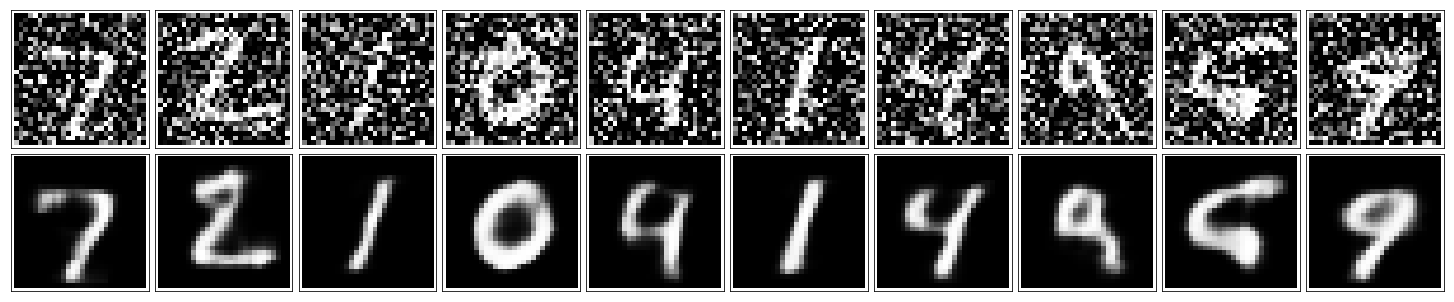

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
imgs = mnist_data.test.images[:10]
noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = session.run(decoded, feed_dict={inputs: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [10]:
session.close()